#### imports

In [1]:
import tensorflow as tf
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import pathlib
import PIL
import PIL.Image

#### parameters

In [2]:
# data
data_dir = pathlib.Path('./data')
data = list(data_dir.glob('*/*.*'))
img_height = 227
img_width = 227

# partitioning
test_set_ratio = 0.1
validation_set_ratio = 0.1

# random
random_seed = 42

# keras
batch_size = 32

# model training
no_of_epochs = 5
no_of_epoch_steps = 5

#### load all data

In [3]:
ds_all = tf.keras.utils.image_dataset_from_directory(
    batch_size = batch_size,
    directory = data_dir,
    image_size = (img_height, img_width), # resized image dimensions
    seed = random_seed) # ensure known random_seed is used (for consistency)
ds_all_class_names = ds_all.class_names

Found 555 files belonging to 2 classes.


In [4]:
print(ds_all)

<BatchDataset shapes: ((None, 227, 227, 3), (None,)), types: (tf.float32, tf.int32)>


In [5]:
img_scale = 0.1
img_col_count = 3
img_row_count = 3

def show_imgs(ds):
    plt.figure(figsize=(img_height * img_scale, img_width * img_scale))
    for images, labels in ds.take(1):
        for i in range(img_col_count * img_row_count):
            ax = plt.subplot(img_row_count, img_col_count, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(ds_all_class_names[labels[i]])
            plt.axis("off")

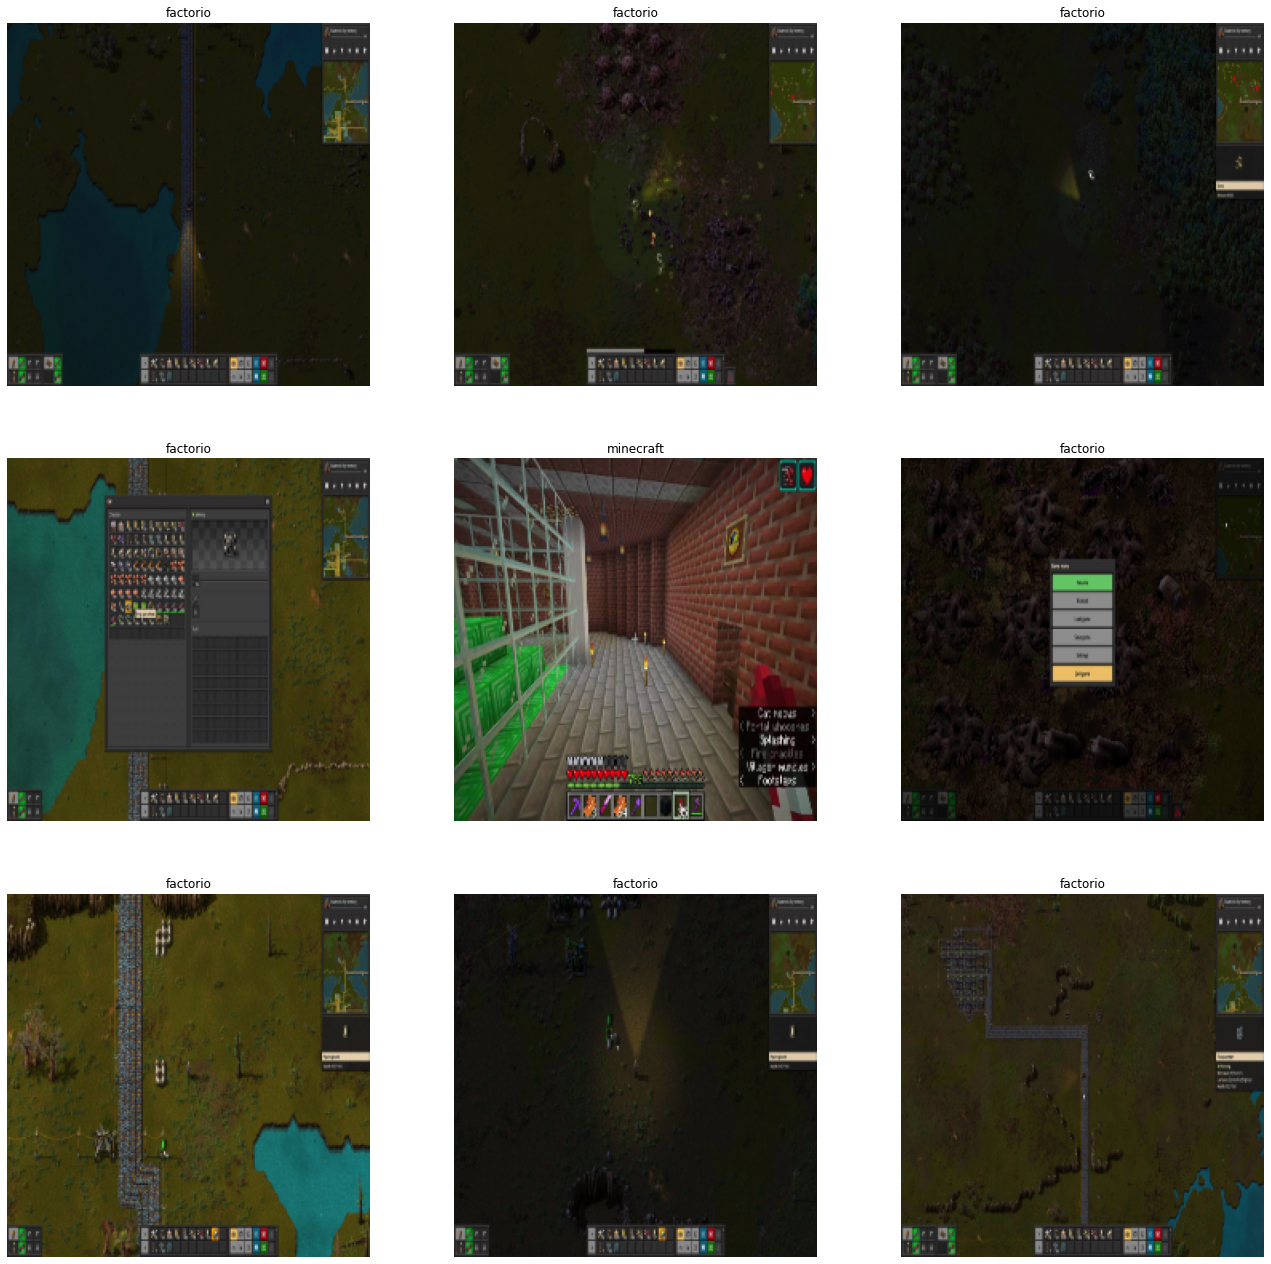

In [6]:
show_imgs(ds_all)

#### partition data

In [7]:
ds_all_size = ds_all.__len__().numpy()
print("ds_all_size        => " + str(ds_all_size))

# use first batches for test and validation as these are full batches (last batch might be partial batch)
ds_test_size       = max(1, int(ds_all_size * test_set_ratio      ))
ds_validation_size = max(1, int(ds_all_size * validation_set_ratio))
print("ds_test_size       => " + str(ds_test_size))
print("ds_validation_size => " + str(ds_validation_size))

# training set becomes rest
ds_training_size = ds_all_size - ds_validation_size - ds_test_size
print("ds_training_size   => " + str(ds_training_size))

ds_all_size        => 18
ds_test_size       => 1
ds_validation_size => 1
ds_training_size   => 16


In [8]:
ds_test       = ds_all                                        .take(ds_test_size      )
ds_validation = ds_all.skip(ds_test_size                     ).take(ds_validation_size)
ds_training   = ds_all.skip(ds_test_size + ds_validation_size).take(ds_training_size  )

ds_training_repeated = ds_training.repeat()

# check sizes
print("ds_test      .__len__() => " + str(ds_test      .__len__().numpy()))
print("ds_validation.__len__() => " + str(ds_validation.__len__().numpy()))
print("ds_training  .__len__() => " + str(ds_training  .__len__().numpy()))

ds_test      .__len__() => 1
ds_validation.__len__() => 1
ds_training  .__len__() => 16


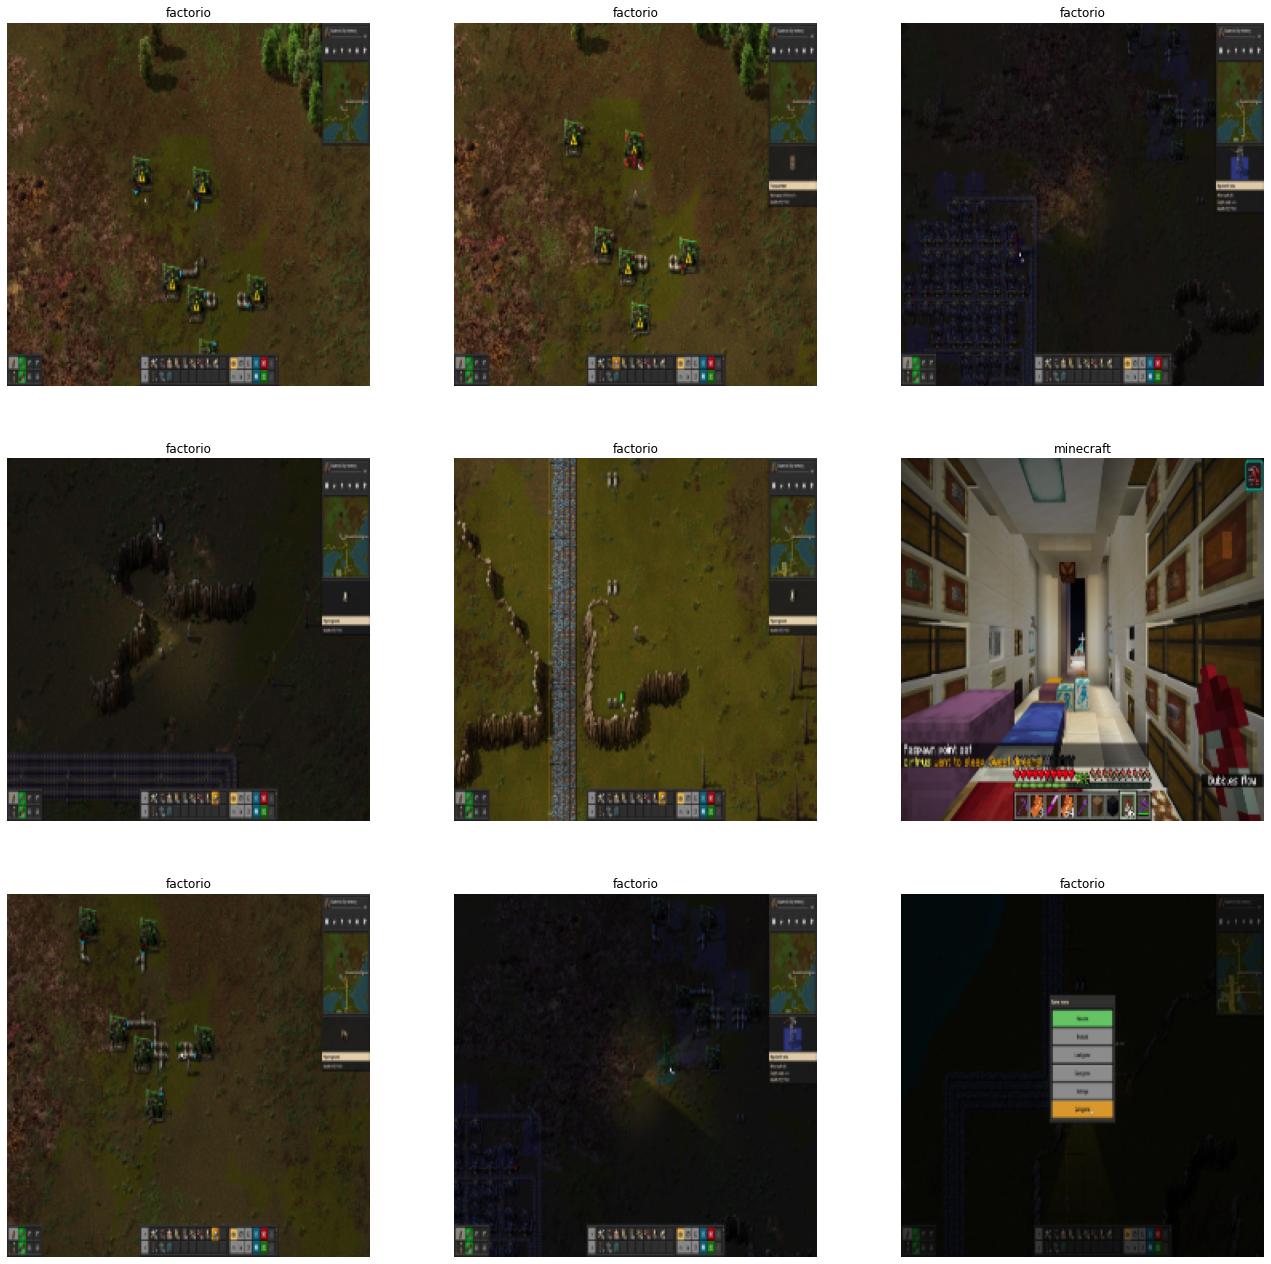

In [9]:
show_imgs(ds_test)

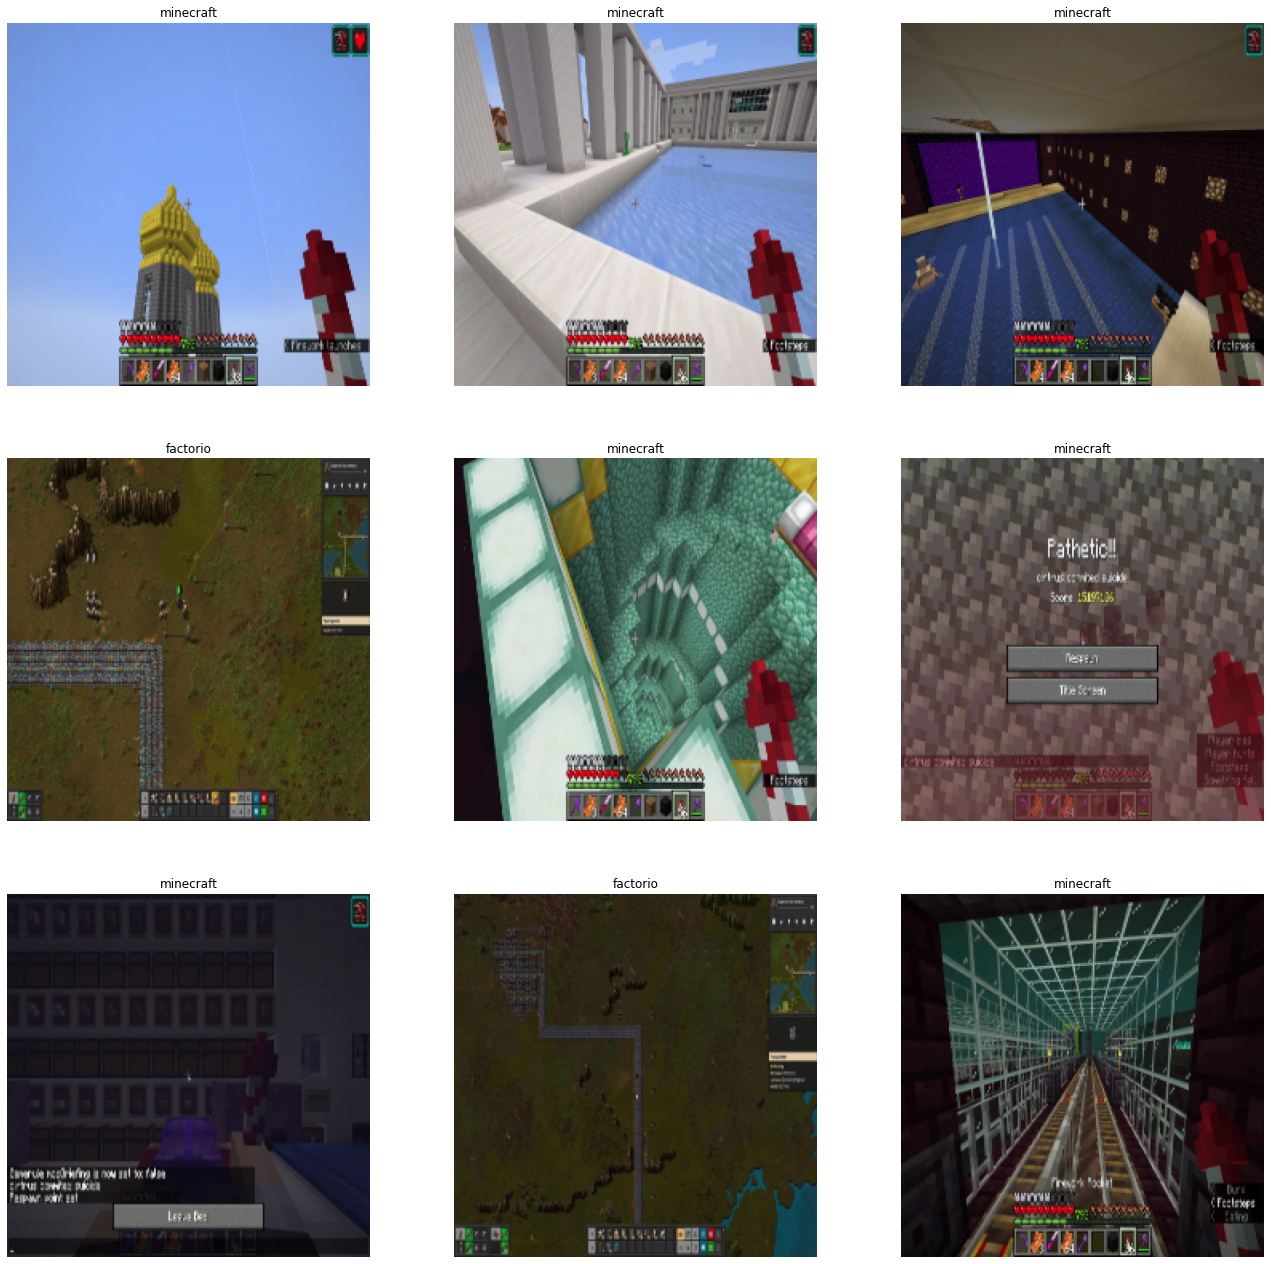

In [10]:
show_imgs(ds_validation)

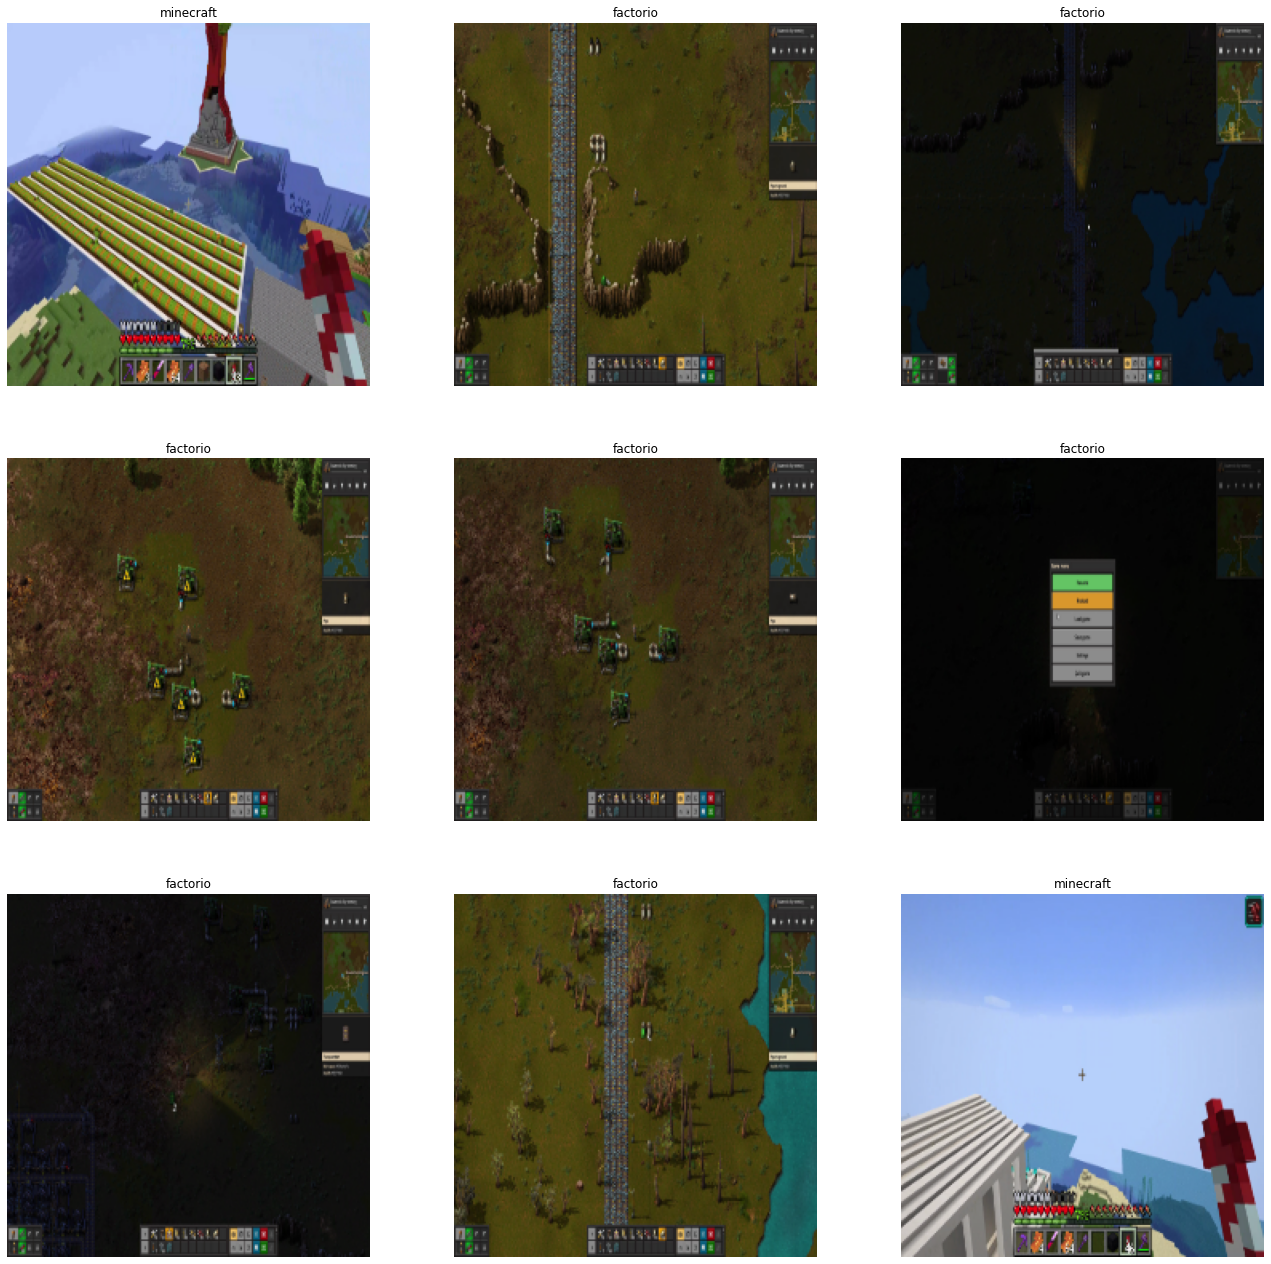

In [11]:
show_imgs(ds_training)

#### base model 1

In [12]:
base_model_1 = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top = False,
    input_shape = (img_height, img_width, 3),
    pooling = 'max', # ( None | avg | max )
    weights = 'imagenet') # ( None | imagenet | path to weights file)

for layer in base_model_1.layers:
    layer.trainable = False

#### model 1.1

In [13]:
# add convolution layers to base model
model_1_1 = tf.keras.Sequential([
    base_model_1,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(2, 'softmax')
])

model_1_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 24,745,730
Trainable params: 1,180,930
Non-trainable params: 23,564,800
_________________________________________________________________


In [14]:
model_1_1.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer = tf.keras.optimizers.Adam())

In [15]:
history_1_1 = model_1_1.fit(
    ds_training_repeated,
    epochs = no_of_epochs,
    steps_per_epoch = no_of_epoch_steps) # ( None (not with infinite datasets) | int )

Epoch 1/5
5/5 [==============================] - 59s 10s/step - loss: 52.9001 - sparse_categorical_accuracy: 0.6062
Epoch 2/5
5/5 [==============================] - 43s 8s/step - loss: 19.4583 - sparse_categorical_accuracy: 0.8687
Epoch 3/5
5/5 [==============================] - 49s 9s/step - loss: 10.6090 - sparse_categorical_accuracy: 0.9250
Epoch 4/5
5/5 [==============================] - 61s 14s/step - loss: 1.6934 - sparse_categorical_accuracy: 0.9640
Epoch 5/5
5/5 [==============================] - 68s 14s/step - loss: 4.4113 - sparse_categorical_accuracy: 0.9563


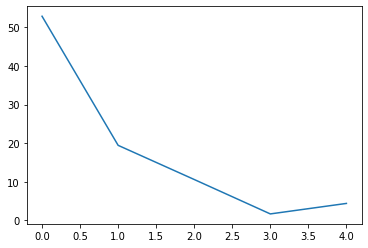

In [16]:
plt.plot(history_1_1.history['loss'])

In [17]:
model_1_1.save('akt_net_model_1_1.h5')

/usr/local/lib/python3.6/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [18]:
model_reloaded_1_1 = tf.keras.models.load_model('akt_net_model_1_1.h5')

#### model 1.2

In [19]:
# add convolution layers to base model
model_1_2 = tf.keras.Sequential([
    base_model_1,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(2, 'softmax')
])

model_1_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_3 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 1026      
Total params: 24,614,914
Trainable params: 1,050,114
Non-trainable params: 23,564,800
_________________________________________________________________


In [20]:
model_1_2.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer = tf.keras.optimizers.Adam())

In [21]:
history_1_2 = model_1_2.fit(
    ds_training_repeated,
    epochs = no_of_epochs,
    steps_per_epoch = no_of_epoch_steps) # ( None (not with infinite datasets) | int )

Epoch 1/5
5/5 [==============================] - 54s 10s/step - loss: 222.2570 - sparse_categorical_accuracy: 0.5875
Epoch 2/5
5/5 [==============================] - 46s 9s/step - loss: 42.7297 - sparse_categorical_accuracy: 0.7500
Epoch 3/5
5/5 [==============================] - 42s 9s/step - loss: 20.5574 - sparse_categorical_accuracy: 0.9000
Epoch 4/5
5/5 [==============================] - 39s 9s/step - loss: 8.4440 - sparse_categorical_accuracy: 0.9209
Epoch 5/5
5/5 [==============================] - 49s 9s/step - loss: 3.6859 - sparse_categorical_accuracy: 0.9688


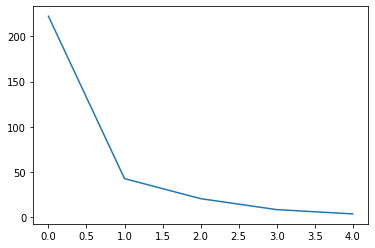

In [22]:
plt.plot(history_1_2.history['loss'])

In [23]:
model_1_2.save('akt_net_model_1_2.h5')

In [24]:
model_reloaded_1_2 = tf.keras.models.load_model('akt_net_model_1_2.h5')

#### base model 2

In [25]:
base_model_2 = tf.keras.applications.resnet_v2.ResNet50V2(
    include_top = False,
    input_shape = (img_height, img_width, 3),
    pooling = 'avg', # ( None | avg | max )
    weights = 'imagenet') # ( None | imagenet | path to weights file)

for layer in base_model_2.layers:
    layer.trainable = False

#### model 2.1

In [26]:
# add convolution layers to base model
model_2_1 = tf.keras.Sequential([
    base_model_2,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(256, 'relu'),
    tf.keras.layers.Dense(2, 'softmax')
])

model_2_1.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 514       
Total params: 24,745,730
Trainable params: 1,180,930
Non-trainable params: 23,564,800
_________________________________________________________________


In [27]:
model_2_1.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer = tf.keras.optimizers.Adam())

In [28]:
history_2_1 = model_2_1.fit(
    ds_training_repeated,
    epochs = no_of_epochs,
    steps_per_epoch = no_of_epoch_steps) # ( None (not with infinite datasets) | int )

Epoch 1/5
5/5 [==============================] - 55s 10s/step - loss: 57.9170 - sparse_categorical_accuracy: 0.5500
Epoch 2/5
5/5 [==============================] - 45s 9s/step - loss: 24.3837 - sparse_categorical_accuracy: 0.5750
Epoch 3/5
5/5 [==============================] - 48s 9s/step - loss: 7.5264 - sparse_categorical_accuracy: 0.7250
Epoch 4/5
5/5 [==============================] - 37s 9s/step - loss: 2.8985 - sparse_categorical_accuracy: 0.7842
Epoch 5/5
5/5 [==============================] - 55s 11s/step - loss: 0.9821 - sparse_categorical_accuracy: 0.9062


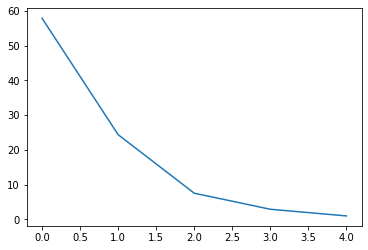

In [29]:
plt.plot(history_2_1.history['loss'])

In [30]:
model_2_1.save('akt_net_model_2_1.h5')

In [31]:
model_reloaded_2_1 = tf.keras.models.load_model('akt_net_model_2_1.h5')

#### model 2.2

In [32]:
# add convolution layers to base model
model_2_2 = tf.keras.Sequential([
    base_model_2,
    tf.keras.layers.Dense(512, 'relu'),
    tf.keras.layers.Dense(2, 'softmax')
])

model_2_2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 1026      
Total params: 24,614,914
Trainable params: 1,050,114
Non-trainable params: 23,564,800
_________________________________________________________________


In [33]:
model_2_2.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics = [tf.keras.metrics.SparseCategoricalAccuracy()],
    optimizer = tf.keras.optimizers.Adam())

In [34]:
history_2_2 = model_2_2.fit(
    ds_training_repeated,
    epochs = no_of_epochs,
    steps_per_epoch = no_of_epoch_steps) # ( None (not with infinite datasets) | int )

Epoch 1/5
5/5 [==============================] - 56s 9s/step - loss: 74.0574 - sparse_categorical_accuracy: 0.5375
Epoch 2/5
5/5 [==============================] - 41s 7s/step - loss: 30.2715 - sparse_categorical_accuracy: 0.5875
Epoch 3/5
5/5 [==============================] - 74s 17s/step - loss: 15.5256 - sparse_categorical_accuracy: 0.7750
Epoch 4/5
5/5 [==============================] - 52s 12s/step - loss: 16.0060 - sparse_categorical_accuracy: 0.6906
Epoch 5/5
5/5 [==============================] - 41s 9s/step - loss: 3.4539 - sparse_categorical_accuracy: 0.8875


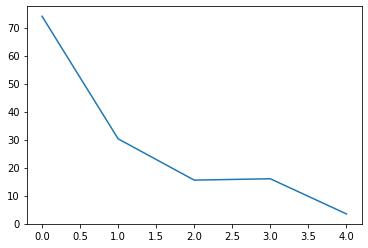

In [35]:
plt.plot(history_2_2.history['loss'])

In [36]:
model_2_2.save('akt_net_model_2_2.h5')

In [37]:
model_reloaded_2_2 = tf.keras.models.load_model('akt_net_model_2_2.h5')

#### Compare results

In [38]:
eval_1_1 = model_1_1.evaluate(ds_validation)

1/1 [==============================] - 15s 15s/step - loss: 4.5755 - sparse_categorical_accuracy: 0.9375


In [39]:
eval_1_2 = model_1_2.evaluate(ds_validation)

1/1 [==============================] - 19s 19s/step - loss: 4.3422 - sparse_categorical_accuracy: 0.9688


In [40]:
eval_2_1 = model_2_1.evaluate(ds_validation)

1/1 [==============================] - 28s 28s/step - loss: 2.0129 - sparse_categorical_accuracy: 0.9062


In [41]:
eval_2_2 = model_2_2.evaluate(ds_validation)

1/1 [==============================] - 22s 22s/step - loss: 4.2870 - sparse_categorical_accuracy: 0.7500


#### Use best model for evaluation on test data

In [47]:
model_1_2.evaluate(ds_test)

1/1 [==============================] - 15s 15s/step - loss: 6.3363 - sparse_categorical_accuracy: 0.9375


[6.33631706237793, 0.9375]

In [51]:
list(map(lambda x: ds_all_class_names[x], np.argmax(model_1_2.predict(ds_test), axis=1)))

['minecraft',
 'factorio',
 'factorio',
 'minecraft',
 'factorio',
 'minecraft',
 'minecraft',
 'minecraft',
 'factorio',
 'factorio',
 'factorio',
 'minecraft',
 'factorio',
 'factorio',
 'factorio',
 'factorio',
 'factorio',
 'minecraft',
 'factorio',
 'minecraft',
 'factorio',
 'minecraft',
 'minecraft',
 'factorio',
 'minecraft',
 'minecraft',
 'factorio',
 'minecraft',
 'factorio',
 'factorio',
 'factorio',
 'minecraft']

#### Findings

* Utilizing pretrained neural nets the classification works better than expected.
  * Number of epochs and steps per epoch had to be reduced to have a noticeable difference between the models.
  * With more epochs and steps each model came close to 1.0 sparse categorical accuracy.
* Factorio and Minecraft seem to be no challenge for a neural net
  * different color scheme
  * different UIs
* Small errors break the whole program quickly.
* Major challenge was the fight against python and tensorflow (syntax and how to do things).
  * Switched to tensorflow 2.6.0 to have better documentation.
* Model 1.2 was the winner.
  * Interesting because it has one dense layer less than model 1.1.
  * Probably would have lost to model 1.1 if training was longer. (Model 1.1 got worse in last epoch.)